In [ ]:
!pip install openpyxl  --quiet

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
import string
import tensorflow as tf
import re
import os
import time
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [3]:
ENCODER_LEN = 100
DECODER_LEN = 20
BATCH_SIZE = 64
BUFFER_SIZE = BATCH_SIZE*8

In [7]:
duc=pd.read_excel("/content/drive/MyDrive/Colab Notebooks/DL/Datasets/duc_2004.xlsx",engine = 'openpyxl')

In [8]:
duc.head()

,text,summary1,summary2,summary3,summary4
0,cambodian leader hun sen on friday rejected op...,Cambodian government rejects opposition's call...,Cambodian leader Hun Sen rejects opposition de...,"Hun Sen rejects out of country talks, Sihanouk...",New Cambodian government in limbo as Hun Sen r...
1,king norodom sihanouk has declined requests to...,Sihanouk refuses to chair Cambodian political ...,Sihanouk refuses to host talks of Cambodian po...,"Efforts to form a government deadlocked, Sihan...",Norodom Sihanouk declines role to mediate in C...
2,cambodia 's two-party opposition asked the asi...,"Opposition asks end to loans to ""illegal"" Camb...",Cambodian opposition asks ADB to stop loans to...,Cambodia's two-party opposition seeks to block...,Opponents of Cambodian government ask Asian De...
3,cambodia 's ruling party responded tuesday to ...,Cambodian party defends leader Hun Sen against...,CPP defends Hun Sen to US Senate. Asks rejecti...,Cambodia's ruling party seeks to counter human...,US House seeks probe of Cambodian rights viola...
4,cambodia 's leading opposition party ruled out...,Cambodian party rejects government offer to sh...,FUNCINPEC refuses to share presidency with CPP...,Disputes over presidency block efforts to form...,Opposition Royalists reject power sharing and ...


In [9]:
news = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/DL/Datasets/inshorts.xlsx",engine = 'openpyxl')
news.drop(['Source ', 'Time ', 'Publish Date'], axis=1, inplace=True)
news.head()
print(f'Dataset size: {len(news)}')

Dataset size: 55104


In [10]:
duc_columns = duc.columns.tolist()
duc_columns.remove('text')
duc_columns.remove('summary1')
duc.drop(duc_columns, axis='columns', inplace=True)

In [11]:
duc

,text,summary1
0,cambodian leader hun sen on friday rejected op...,Cambodian government rejects opposition's call...
1,king norodom sihanouk has declined requests to...,Sihanouk refuses to chair Cambodian political ...
2,cambodia 's two-party opposition asked the asi...,"Opposition asks end to loans to ""illegal"" Camb..."
3,cambodia 's ruling party responded tuesday to ...,Cambodian party defends leader Hun Sen against...
4,cambodia 's leading opposition party ruled out...,Cambodian party rejects government offer to sh...
...,...,...
495,"german foreign minister joschka fischer , who ...",German Foreign Minister says China's arrest of...
496,the trials of three outspoken dissidents over ...,President Jiang vows to crush any challenges t...
497,"his friend and political mentor is jailed , ro...",China Democracy Party vows to campaign for cha...
498,by sentencing two of the country 's most promi...,China's arrest of dissidents could destroy Chi...


In [12]:
duc.rename(columns = { 'summary1':'Headline','text':'Short'}, inplace = True)

In [13]:
duc

,Short,Headline
0,cambodian leader hun sen on friday rejected op...,Cambodian government rejects opposition's call...
1,king norodom sihanouk has declined requests to...,Sihanouk refuses to chair Cambodian political ...
2,cambodia 's two-party opposition asked the asi...,"Opposition asks end to loans to ""illegal"" Camb..."
3,cambodia 's ruling party responded tuesday to ...,Cambodian party defends leader Hun Sen against...
4,cambodia 's leading opposition party ruled out...,Cambodian party rejects government offer to sh...
...,...,...
495,"german foreign minister joschka fischer , who ...",German Foreign Minister says China's arrest of...
496,the trials of three outspoken dissidents over ...,President Jiang vows to crush any challenges t...
497,"his friend and political mentor is jailed , ro...",China Democracy Party vows to campaign for cha...
498,by sentencing two of the country 's most promi...,China's arrest of dissidents could destroy Chi...


In [14]:
news

,Headline,Short
0,4 ex-bank officials booked for cheating bank o...,The CBI on Saturday booked four former officia...
1,Supreme Court to go paperless in 6 months: CJI,Chief Justice JS Khehar has said the Supreme C...
2,"At least 3 killed, 30 injured in blast in Sylh...","At least three people were killed, including a..."
3,Why has Reliance been barred from trading in f...,Mukesh Ambani-led Reliance Industries (RIL) wa...
4,Was stopped from entering my own studio at Tim...,TV news anchor Arnab Goswami has said he was t...
...,...,...
55099,Sensex loses 400 points to hit 52-week low,"Tracking weak cues from the Asian markets, the..."
55100,China to inject $91 bn into the money markets,Amid growing concerns about China&#39;s econom...
55101,Ghulam Ali set to make acting debut in Bollywood,Pakistani Ghazal singer Ghulam Ali will soon m...
55102,IS acknowledges death of Jihadi John: Report,The Islamic State (IS) has acknowledged the de...


In [15]:
#df = pd.concat([duc, news])
#del df1, df2
df = pd.concat([duc, news], ignore_index=True, sort=False)
# Shuffling the df
df = df.sample(frac=1).reset_index(drop=True)

print(f'Dataset size: {len(df)}')
news=df

Dataset size: 55604


In [16]:
news.head()

,Short,Headline
0,Malaysian political cartoonist Zulkiflee Ulhaq...,Malaysia arrests political cartoonist under se...
1,India is implementing a project to provide uni...,Govt to give unique ID cards to disabled persons
2,A video explains how the movement of blood exe...,Video: What is blood pressure?
3,"Senior AIADMK leader O Panneerselvam, who beca...",Panneerselvam broke down while taking oath as ...
4,University of Toronto scientists have discover...,World&#39;s oldest water sample found to be 2 ...


In [18]:
news=news.replace(r'&#45;','-', regex=True).replace(r'&#39;','`', regex=True).replace(r'&amp','&', regex=True).replace(r'&#34;','"', regex=True)
news.head()

,Short,Headline
0,Malaysian political cartoonist Zulkiflee Ulhaq...,Malaysia arrests political cartoonist under se...
1,India is implementing a project to provide uni...,Govt to give unique ID cards to disabled persons
2,A video explains how the movement of blood exe...,Video: What is blood pressure?
3,"Senior AIADMK leader O Panneerselvam, who beca...",Panneerselvam broke down while taking oath as ...
4,University of Toronto scientists have discover...,World`s oldest water sample found to be 2 bill...


In [19]:
article = news['Short']
summary = news['Headline']



article = article.apply(lambda x: '<SOS> ' + x + ' <EOS>')
summary = summary.apply(lambda x: '<SOS> ' + x + ' <EOS>')

In [20]:
def preprocess(text):
    text = re.sub(r"&.[1-9]+;"," ",text)
    return text
article = article.apply(lambda x: preprocess(x))
summary = summary.apply(lambda x: preprocess(x))

In [ ]:
article[8]

'<SOS> Indian Air Force Chief Arup Raha on Wednesday said that the One Rank One Pension (OROP) scheme of the Central government is `reasonably good` and we should accept it. "Some of the anomalies and the discrepancies which cropped up from the transition from the sixth to seventh pay commission have been resolved...others will also be resolved," he added. <EOS>'

In [ ]:
print("****************************")
summary[8]

****************************


'<SOS> OROP by the govt is reasonably good: IAF Chief Arup Raha <EOS>'

In [21]:
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
oov_token = '<unk>'
article_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token=oov_token)
summary_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)
article_tokenizer.fit_on_texts(article)
summary_tokenizer.fit_on_texts(summary)
inputs = article_tokenizer.texts_to_sequences(article)
targets = summary_tokenizer.texts_to_sequences(summary)

In [22]:
ENCODER_VOCAB = len(article_tokenizer.word_index) + 1
DECODER_VOCAB = len(summary_tokenizer.word_index) + 1
print(ENCODER_VOCAB, DECODER_VOCAB)

76618 29955


In [23]:
# Padding ensures that all sequences are of uniform length, which is crucial for training neural networks.
# Casting to int64 ensures that the data type aligns with the expected input for TensorFlow models (some layers or operations might need int64).
inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=ENCODER_LEN, padding='post', truncating='post')
targets = tf.keras.preprocessing.sequence.pad_sequences(targets, maxlen=DECODER_LEN, padding='post', truncating='post')
inputs = tf.cast(inputs, dtype=tf.int64)
targets = tf.cast(targets, dtype=tf.int64)

In [24]:
dataset = tf.data.Dataset.from_tensor_slices((inputs, targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

vanilla transformer

In [25]:
def get_angles(position, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)
    return output, attention_weights

In [26]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)

        return output, attention_weights

def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

In [27]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

In [28]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)


    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2

In [29]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        # Embedding and positional encoding layers
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        # Encoder layers (list of EncoderLayer instances)
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        # Apply embedding and positional encoding
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        # Pass through each encoder layer
        for i in range(self.num_layers):
            # Make sure mask is passed as keyword argument
            x = self.enc_layers[i](x, training=training, mask=mask)

        return x


class Decoder(tf.keras.layers.Layer):

    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        # Embedding and positional encoding layers
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        # Decoder layers (list of DecoderLayer instances)
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        # Apply embedding and positional encoding
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        # Pass through each decoder layer
        for i in range(self.num_layers):
            # Pass the look_ahead_mask and padding_mask as keyword arguments
            x, block1, block2 = self.dec_layers[i](x, enc_output, training=training, look_ahead_mask=look_ahead_mask, padding_mask=padding_mask)

            # Save the attention weights for later inspection
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        return x, attention_weights

In [30]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        # Pass the input through the encoder
        enc_output = self.encoder(x=inp, training=training, mask=enc_padding_mask)

        # Pass the target and encoder output through the decoder
        dec_output, attention_weights = self.decoder(
            x=tar, enc_output=enc_output, training=training,
            look_ahead_mask=look_ahead_mask, padding_mask=dec_padding_mask
        )

        # Pass the decoder output through the final linear layer
        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

In [31]:
num_layers = 3
d_model = 128
dff = 512
num_heads = 4
dropout_rate = 0.2
EPOCHS = 30

custom learning rate

In [32]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        # Cast step to float32 for compatibility with tf.math.rsqrt
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [33]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Text(0.5, 0, 'Train Step')

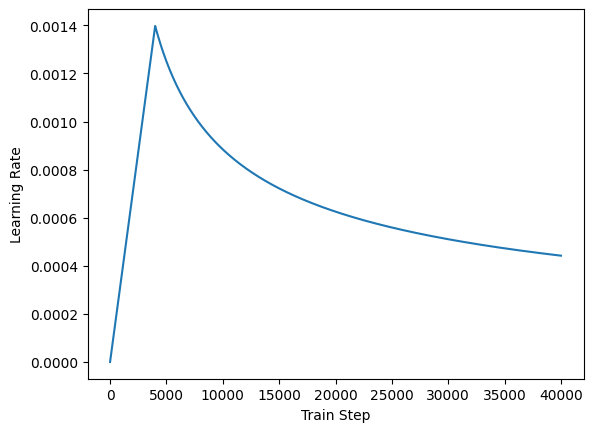

In [34]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

custom loss and accuracy

In [35]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))
    #accuracies = tf.cast(accuracies, dtype= tf.float32)

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [36]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [37]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=ENCODER_VOCAB,
    target_vocab_size=DECODER_VOCAB,
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [38]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # shape: (size, size)

In [39]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)  # Mask for the encoder input
    dec_padding_mask = create_padding_mask(inp)  # Mask for the encoder input used in the decoder

    # Create a look-ahead mask for the target sequence
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])

    # Mask for the target sequence, combining look-ahead and padding mask
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask, look_ahead_mask

In [40]:
checkpoint_path = "checkpoints"

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [41]:
@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    # Generate necessary masks
    enc_padding_mask, combined_mask, dec_padding_mask, look_ahead_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        # Pass arguments as keyword arguments
        predictions, _ = transformer(
            inp=inp,  # input sequence
            tar=tar_inp,  # target sequence
            training=True,  # specify the training mode
            enc_padding_mask=enc_padding_mask,  # encoder padding mask
            dec_padding_mask=dec_padding_mask,  # decoder padding mask
            look_ahead_mask=look_ahead_mask  # look-ahead mask
        )

        # Calculate loss
        loss = loss_function(tar_real, predictions)

    # Compute gradients and update model weights
    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    # Update training metrics
    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

In [43]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.1 MB/s eta 0:00:00


In [ ]:
import optuna
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

# Function to create Transformer model
def create_transformer(trial):
    num_layers = trial.suggest_int("num_layers", 2, 6)
    d_model = trial.suggest_int("d_model", 64, 512, step=64)
    num_heads = trial.suggest_int("num_heads", 2, 8, step=2)
    dff = trial.suggest_int("dff", 256, 1024, step=128)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)

    return Transformer(
        num_layers=num_layers,
        d_model=d_model,
        num_heads=num_heads,
        dff=dff,
        input_vocab_size=ENCODER_VOCAB,
        target_vocab_size=DECODER_VOCAB,
        pe_input=1000,
        pe_target=1000,
        rate=dropout_rate,
    )

# Objective function for Optuna
def objective(trial):
    k = 5  # Number of folds for cross-validation
    kf = KFold(n_splits=k)

    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    transformer = create_transformer(trial)

    def train_step(inp, tar):
        tar_inp = tar[:, :-1]
        tar_real = tar[:, 1:]

        enc_padding_mask, combined_mask, dec_padding_mask, look_ahead_mask = create_masks(inp, tar_inp)

        with tf.GradientTape() as tape:
            predictions, _ = transformer(
                inp=inp,
                tar=tar_inp,
                training=True,
                enc_padding_mask=enc_padding_mask,
                dec_padding_mask=dec_padding_mask,
                look_ahead_mask=look_ahead_mask,
            )
            loss = loss_function(tar_real, predictions)

        gradients = tape.gradient(loss, transformer.trainable_variables)
        optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    def evaluate(inp, tar):
        tar_inp = tar[:, :-1]
        tar_real = tar[:, 1:]

        enc_padding_mask, combined_mask, dec_padding_mask, look_ahead_mask = create_masks(inp, tar_inp)

        predictions, _ = transformer(
            inp=inp,
            tar=tar_inp,
            training=False,
            enc_padding_mask=enc_padding_mask,
            dec_padding_mask=dec_padding_mask,
            look_ahead_mask=look_ahead_mask,
        )
        return tar_real.numpy(), tf.argmax(predictions, axis=-1).numpy()

    # Convert tf.data.Dataset to NumPy arrays
    inputs_np, targets_np = [], []
    for batch_inputs, batch_targets in dataset:
        inputs_np.extend(batch_inputs.numpy())
        targets_np.extend(batch_targets.numpy())
    inputs_np = np.array(inputs_np)
    targets_np = np.array(targets_np)

    val_f1_scores = []

    for train_idx, val_idx in kf.split(inputs_np):
        train_inputs, val_inputs = inputs_np[train_idx], inputs_np[val_idx]
        train_targets, val_targets = targets_np[train_idx], targets_np[val_idx]

        # Create tf.data.Datasets for training and validation
        train_data = tf.data.Dataset.from_tensor_slices((train_inputs, train_targets)).batch(BATCH_SIZE)
        val_data = tf.data.Dataset.from_tensor_slices((val_inputs, val_targets)).batch(BATCH_SIZE)


        for epoch in range(EPOCHS):
            for batch, (inp, tar) in enumerate(train_data):
                train_step(inp, tar)

        # Evaluate on validation set
        val_true, val_pred = [], []
        for inp, tar in val_data:
            true, pred = evaluate(inp, tar)
            val_true.extend(true.flatten())
            val_pred.extend(pred.flatten())

        # Compute F1 Score for the fold
        val_f1_scores.append(f1_score(val_true, val_pred, average="weighted"))

    # Return the mean F1 score across all folds as the objective to maximize
    return sum(val_f1_scores) / len(val_f1_scores)

# Run Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# Print the best hyperparameters
print("Best hyperparameters:", study.best_params)


[I 2024-12-03 17:02:48,856] A new study created in memory with name: no-name-fe36646d-94fa-40d3-a574-1fb12a717ff5
<ipython-input-46-0aac8341d8bd>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


training the model

In [ ]:
for epoch in range(EPOCHS):
    start = time.time()

    # Reset metrics at the start of each epoch
    train_loss.reset_state()
    train_accuracy.reset_state()

    # Loop through each batch in the dataset
    for (batch, (inp, tar)) in enumerate(dataset):
        train_step(inp, tar)  # train_step will call create_masks internally

        if batch % 100 == 0:
            # Print batch-level training loss and accuracy every 100 batches
            print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

    # Save a checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print(f'Saving checkpoint for epoch {epoch + 1} at {ckpt_save_path}')

    # Print epoch-level training loss, accuracy, and time taken
    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
    print(f'Time taken for 1 epoch: {time.time() - start} secs\n')


Epoch 1 Batch 0 Loss 10.3254 Accuracy 0.0000
Epoch 1 Batch 100 Loss 10.2140 Accuracy 0.0579
Epoch 1 Batch 200 Loss 10.0009 Accuracy 0.0806
Epoch 1 Batch 300 Loss 9.7021 Accuracy 0.0882
Epoch 1 Batch 400 Loss 9.3591 Accuracy 0.0920
Epoch 1 Batch 500 Loss 9.0439 Accuracy 0.0943
Epoch 1 Batch 600 Loss 8.7972 Accuracy 0.0961
Epoch 1 Batch 700 Loss 8.6071 Accuracy 0.0997
Epoch 1 Batch 800 Loss 8.4564 Accuracy 0.1028
Epoch 1 Loss 8.3692 Accuracy 0.1049
Time taken for 1 epoch: 129.55477452278137 secs

Epoch 2 Batch 0 Loss 7.2849 Accuracy 0.1341
Epoch 2 Batch 100 Loss 7.2634 Accuracy 0.1349
Epoch 2 Batch 200 Loss 7.2176 Accuracy 0.1372
Epoch 2 Batch 300 Loss 7.1785 Accuracy 0.1387
Epoch 2 Batch 400 Loss 7.1295 Accuracy 0.1401
Epoch 2 Batch 500 Loss 7.0824 Accuracy 0.1415
Epoch 2 Batch 600 Loss 7.0334 Accuracy 0.1432
Epoch 2 Batch 700 Loss 6.9821 Accuracy 0.1449
Epoch 2 Batch 800 Loss 6.9333 Accuracy 0.1467
Epoch 2 Loss 6.9002 Accuracy 0.1479
Time taken for 1 epoch: 94.55405306816101 secs

Epoc

In [ ]:
plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

NameError: name 'history' is not defined

evaluation

In [ ]:
# def evaluate(input_article):
#     input_article = article_tokenizer.texts_to_sequences([input_article])
#     input_article = tf.keras.preprocessing.sequence.pad_sequences(input_article, maxlen=ENCODER_LEN,
#                                                                    padding='post', truncating='post')

#     encoder_input = tf.expand_dims(input_article[0], 0)

#     decoder_input = [summary_tokenizer.word_index['<sos>']]
#     output = tf.expand_dims(decoder_input, 0)

#     for i in range(DECODER_LEN):
#         enc_padding_mask, combined_mask, dec_padding_mask, look_ahead_mask = create_masks(encoder_input, output)

#         predictions, attention_weights = transformer(
#             encoder_input,
#             output,
#             False,
#             enc_padding_mask,
#             combined_mask,
#             dec_padding_mask,
#             look_ahead_mask
#         )

#         predictions = predictions[: ,-1:, :]
#         predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

#         if predicted_id == summary_tokenizer.word_index['<eos>']:
#             return tf.squeeze(output, axis=0), attention_weights

#         output = tf.concat([output, predicted_id], axis=-1)

#     return tf.squeeze(output, axis=0), attention_weights

def evaluate(input_article):
    input_article = article_tokenizer.texts_to_sequences([input_article])
    input_article = tf.keras.preprocessing.sequence.pad_sequences(input_article, maxlen=ENCODER_LEN,
                                                                   padding='post', truncating='post')

    encoder_input = tf.expand_dims(input_article[0], 0)

    decoder_input = [summary_tokenizer.word_index['<sos>']]
    output = tf.expand_dims(decoder_input, 0)

    for i in range(DECODER_LEN):
        enc_padding_mask, combined_mask, dec_padding_mask, look_ahead_mask = create_masks(encoder_input, output)

        # Call transformer without combined_mask if it's not expected
        predictions, attention_weights = transformer(
            encoder_input,
            output,
            training=False,  # Fix: passed as keyword argument
            enc_padding_mask=enc_padding_mask,
            dec_padding_mask=dec_padding_mask,
            look_ahead_mask=look_ahead_mask  # If combined_mask is not needed, leave it out
        )

        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if predicted_id == summary_tokenizer.word_index['<eos>']:
            return tf.squeeze(output, axis=0), attention_weights

        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights


In [ ]:
def summarize(input_article):
    input_article=preprocess(input_article)
    summarized = evaluate(input_article=input_article)[0].numpy()
    summarized = np.expand_dims(summarized[1:], 0)
    return summary_tokenizer.sequences_to_texts(summarized)[0]

predictions

In [ ]:
article[6]

'<SOS> The Shah Rukh Khan and Alia Bhatt starrer `Dear Zindagi` "could have done with... more plot," wrote The Indian Express. The film`s story "much like its protagonist, is stuck in a rut," said India Today. Hindustan Times wrote that "the screenplay and dialogues... stop the film from being magnificent". It has been rated 1.5/5 (TIE), 2/5 (HT) and 3/5 (IT). <EOS>'

In [ ]:
print("Real Headline : ", summary[6][5:-5],"\n Predicted Summary : ", summarize(article[6]))

Real Headline :   SRK, Alia Bhatt starrer `Dear Zindagi` hits theatres  
 Predicted Summary :  srk alia bhatt starrer dear zindagi hits theatres


In [ ]:
article[16]

'<SOS> The government has offered Saudi Arabia a stake in the oil refinery and petrochemicals project proposed along Maharashtra coast at an estimated cost of ₹1.5 lakh crore, Oil Minister Dharmendra Pradhan said on Monday. The minister added that the work on the 60-million tonne project will begin once the state government identifies and acquires the land.\\n <EOS>'

In [ ]:
print("Real Headline : ", summary[16][5:-5],"\nPredicted Summary : ", summarize(article[16]))

Real Headline :   Saudi offered stake in Maharashtra oil project  
Predicted Summary :  saudi offers stake in maharashtra oil project


In [ ]:
article[23]

'<SOS> Google on Monday launched its video calling app Duo, that will rival Microsoft`s Skype. It allows making end-to-end encrypted video calls to a user`s entire contact list on a single tap. To make a call, Duo only requires a user`s phone number. Available for both Android and iOS users, the app will be live worldwide in the next few days. <EOS>'

In [ ]:
print("Real Headline : ", summary[23][5:-5],"\nPredicted Summary : ", summarize(article[23]))

Real Headline :   Google launches video calling app to rival Skype  
Predicted Summary :  google launches video calling app to rival skype


In [ ]:
print("Real Headline : ", summary[0][5:-5],"\nPredicted Summary : ", summarize(article[0]))

Real Headline :   SC quashes Singur land acquisition for Tata Nano plant  
Predicted Summary :  sc upholds hc order for nano acquisition in wb


In [ ]:
print("Real Headline : ", summary[23][5:-5],"\nPredicted Summary : ", summarize(article[23]))

Real Headline :   Google launches video calling app to rival Skype  
Predicted Summary :  google launches video calling app to rival skype


In [ ]:
summarize("Text Summarization - as the name suggests - involves generating short summaries of text data, in a few words or sentences. A good example of this in day-to-day life is the Inshorts news summary app, which generates summaries upto max of ~ 60 words.")

'could undergo rules short film cricket study'

In [ ]:
summarize("""Cambodian leader Hun Sen on Friday rejected opposition parties' demands
for talks outside the country, accusing them of trying to ``internationalize''
the political crisis. Government and opposition parties have asked
King Norodom Sihanouk to host a summit meeting after a series of post-election
negotiations between the two opposition groups and Hun Sen's party
to form a new government failed. Opposition leaders Prince Norodom
Ranariddh and Sam Rainsy, citing Hun Sen's threats to arrest opposition
figures after two alleged attempts on his life, said they could not
negotiate freely in Cambodia and called for talks at Sihanouk's residence
in Beijing. Hun Sen, however, rejected that. ``I would like to make
it clear that all meetings related to Cambodian affairs must be conducted
in the Kingdom of Cambodia,'' Hun Sen told reporters after a Cabinet
meeting on Friday. ``No-one should internationalize Cambodian affairs.
It is detrimental to the sovereignty of Cambodia,'' he said. Hun Sen's
Cambodian People's Party won 64 of the 122 parliamentary seats in
July's elections, short of the two-thirds majority needed to form
a government on its own. Ranariddh and Sam Rainsy have charged that
Hun Sen's victory in the elections was achieved through widespread
fraud. They have demanded a thorough investigation into their election
complaints as a precondition for their cooperation in getting the
national assembly moving and a new government formed. Hun Sen said
on Friday that the opposition concerns over their safety in the country
was ``just an excuse for them to stay abroad.'' Both Ranariddh and
Sam Rainsy have been outside the country since parliament was ceremonially
opened on Sep. 24. Sam Rainsy and a number of opposition figures have
been under court investigation for a grenade attack on Hun Sen's Phnom
Penh residence on Sep. 7. Hun Sen was not home at the time of the
attack, which was followed by a police crackdown on demonstrators
contesting Hun Sen's election victory. The Sam Rainsy Party, in a
statement released Friday, accused Hun Sen of being ``unwilling to
make any compromise'' on negotiations to break the deadlock. ``A meeting
outside Cambodia, as suggested by the opposition, could place all
parties on more equal footing,'' said the statement. ``But the ruling
party refuses to negotiate unless it is able to threaten its negotiating
partners with arrest or worse.'' """)

'cambodian prime minister rejects opposition leader s arrest'

In [ ]:
summarize("cambodian leader hun sen on friday rejected opposition parties ' demands for talks outside the country , accusing them of trying to `` internationalize '' the political crisis .")

'cambodian prime minister rejects call for talks against india’s talks'

In [ ]:
summarize("king norodom sihanouk has declined requests to chair a summit of cambodia 's top political leaders , saying the meeting would not bring any progress in deadlocked negotiations to form a government .")

'king declines to chair cambodian political summit in cambodia'

In [ ]:
summarize("sometime in the summer of 1997 , an operative for osama bin laden sat down at his personal computer in a hideaway in kenya , he was worried , he wrote in an angry dispatch , about the security of the `` east africa network '' of bin laden , the saudi exile accused of masterminding a worldwide terrorist conspiracy against americans .")

'letter from bin laden network observed on operation in kenya'

In [ ]:
summarize("six months after president clinton traveled to beijing and challenged china 's leaders to move rapidly toward political reform , the administration 's policy of engaging beijing was called into question monday when chinese courts sentenced three of the nation 's most prominent dissidents to long jail sentences .")

'u s policy is not possible trade and china democracy party'

In [ ]:
summarize("fbi agents this week began questioning relatives of the victims of the aug. 7 u.s. embassy bombing as well as the seriously injured on request of the u.s. attorney 's office for the southern district of new york , a u.s. official said thursday .")

'fbi questions group for trial of bombing suspects'

In [ ]:
summarize("Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.")

'india s artificial intelligence agency gets growth at ₹500'

In [ ]:
summarize("Actor Ranbir Kapoor worked as an assistant director for Sanjay Leela Bhansali&#39;s &#39;Black&#39; in 2005. He is also known to have assisted in the making of the 1996 film &#39;PremGranth&#39; and his father Rishi Kapoor&#39;s directorial debut &#39;Aa Ab Laut Chalen&#39; in 1999. The actor, who has won five Filmfare awards including Best Actor for &#39;Barfi!&#39;, turned 34 on Wednesday.")

'ranbir worked as assistant director for black'

In [ ]:
print("Real Headline : ", summary[0][5:-5],"\nPredicted Summary : ", summarize(article[0]))

Real Headline :   SC quashes Singur land acquisition for Tata Nano plant  
Predicted Summary :  sc upholds hc order for nano acquisition in wb


In [ ]:
summarize("The CBI on Saturday booked four former officials of Syndicate Bank and six others for cheating, forgery, criminal conspiracy and causing ₹209 crore loss to the state-run bank. The accused had availed home loans and credit from Syndicate Bank on the basis of forged and fabricated documents. These funds were fraudulently transferred to the companies owned by the accused persons.")

'4 ex bank officials booked for cheating bank of 2015 16'